In [1]:
import numpy as np 
import pandas as pd
import math as math
import random
import time

from keras.layers import Input, Dense
from keras.models import Model

import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import *
from shared_module import *

Using TensorFlow backend.


# Hyperparameters
- N_ANCHORS determines the number of anchors we find for each breed
- ENCODING_STRATEGY dictates the image encoding model and the size of the input vector

In [2]:
N_ANCHORS = ANCHORS_12
ENCODING_STRATEGY = VGG19_4096
ENCODING_SIZE = 4096

random.seed()

## Load the pre-processed training file. The training file already contains the anchors and cluster information.


In [3]:
INPUT_FILE_PATH = './input/labels_train_full'

training_file_path = get_path(INPUT_FILE_PATH, N_ANCHORS, ENCODING_STRATEGY)

df_train = pd.read_csv(training_file_path('anchor'))



### Statistics about the breeds in dataset

In [4]:
display(df_train.groupby(['breed']).agg(['count']))

,id,encoding,anp,cluster
,count,count,count,count
breed,,,,
affenpinscher,64,64,64,64
afghan_hound,92,92,92,92
african_hunting_dog,68,68,68,68
airedale,85,85,85,85
american_staffordshire_terrier,59,59,59,59
appenzeller,62,62,62,62
australian_terrier,81,81,81,81
basenji,88,88,88,88


### Breeds and sample of pictures

'total number of breeds 120'

mexican_hairless


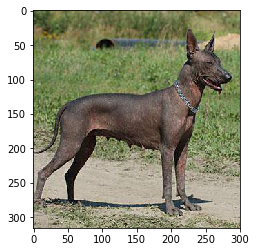

bedlington_terrier


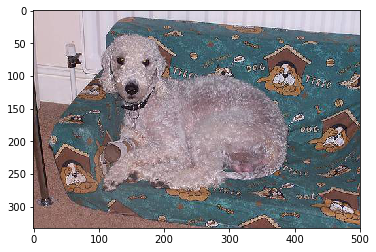

In [5]:
breeds = df_train['breed'].unique()

display('total number of breeds ' + str(len(breeds)))


def sample_by_breed(df_train):
    breeds = df_train['breed'].unique()
    random.seed()
    breed = breeds[random.randint(0, len(breeds) - 1)]
    df_breed = df_train.loc[(df_train['breed'] == breed)]
    random_index = random.randint(0, (df_breed.shape[0] - 1))
    print(breed)
    show_img(df_breed.iloc[random_index].id)

    
def show_img(image_id):
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=image_id))
    plt.imshow(img)
    plt.show()

    
sample_by_breed(df_train)
sample_by_breed(df_train)

## Load the pre-processed triplets training file
## Shuffle the triplets so that we don't just train all of a single breed first 

In [6]:
def shuffle_triplets(df_triplets):
    return df_triplets.sample(frac=1).reset_index(drop=True)

df_triplets = pd.read_csv(training_file_path('triplets'))

df_triplets = shuffle_triplets(df_triplets)
display('Total number of triplets ' + str(df_triplets.shape[0]))

display(df_triplets.head())

'Total number of triplets 11605356'

,anchor_id,anchor_type,anchor_encoding,positive_id,positive_type,positive_encoding,negative_id,negative_type,negative_encoding
0,60589f1c3265c6d79fe0c6ba12009285,staffordshire_bullterrier,./input/vgg19_4096/60589f1c3265c6d79fe0c6ba120...,9a4c68bc356af529465603fc23a5ff28,staffordshire_bullterrier,./input/vgg19_4096/9a4c68bc356af529465603fc23a...,4c49c4389f114434652b25258c10aff3,miniature_pinscher,./input/vgg19_4096/4c49c4389f114434652b25258c1...
1,44c17109d8c8b908d5c96a6fd8ab23c5,maltese_dog,./input/vgg19_4096/44c17109d8c8b908d5c96a6fd8a...,5406eeabc4f6b981cc6f61cc7a335eae,maltese_dog,./input/vgg19_4096/5406eeabc4f6b981cc6f61cc7a3...,c5dd9170863cc99c078f0d4298b0a352,bull_mastiff,./input/vgg19_4096/c5dd9170863cc99c078f0d4298b...
2,6ea6d75a4d0d0a6c349ee5ac041dab97,leonberg,./input/vgg19_4096/6ea6d75a4d0d0a6c349ee5ac041...,13f765ea64c7a3575a105cbdfbb6c31f,leonberg,./input/vgg19_4096/13f765ea64c7a3575a105cbdfbb...,1392df2ceab56cdf380813987c7c9ba5,bouvier_des_flandres,./input/vgg19_4096/1392df2ceab56cdf380813987c7...
3,aee2775bb66001a6b3b48840710c907d,newfoundland,./input/vgg19_4096/aee2775bb66001a6b3b48840710...,338359db9986698fc89157f62dbd617a,newfoundland,./input/vgg19_4096/338359db9986698fc89157f62db...,8de94658ff000fd09d40e16038ce8fae,beagle,./input/vgg19_4096/8de94658ff000fd09d40e16038c...
4,c59df3c5d6b7f12d5086f1b7cf64858b,boston_bull,./input/vgg19_4096/c59df3c5d6b7f12d5086f1b7cf6...,632e8ef55138a10cdcf56a7bd1e125f4,boston_bull,./input/vgg19_4096/632e8ef55138a10cdcf56a7bd1e...,1e19af1794d48529224eab0538eba520,borzoi,./input/vgg19_4096/1e19af1794d48529224eab0538e...


### Show samples of the triplets

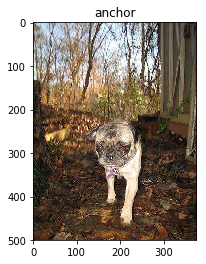

./input/train-2/becbfec66b1e2d7c5ac05cd9d9682931.jpg
pug


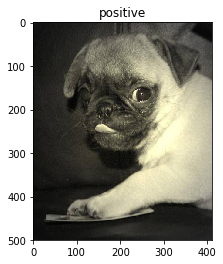

./input/train-2/6496959bd5a27de3cb15e771ca2ae7b3.jpg
pug


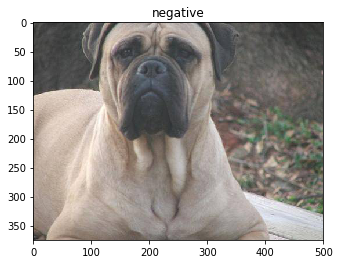

./input/train-2/807b3724a4943e2f6ec5b7cc41b2cf8f.jpg
bull_mastiff


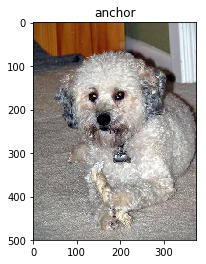

./input/train-2/a32faea2f67d4949761454e07437f9ac.jpg
miniature_poodle


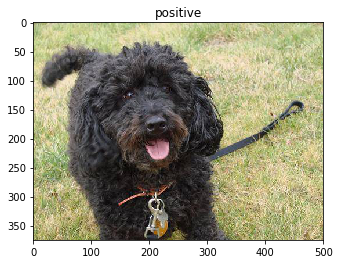

./input/train-2/39625c8e9173a6175d31079f8b9b6b62.jpg
miniature_poodle


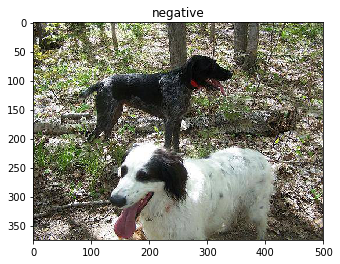

./input/train-2/51e9383e1158e6ef4bc8213c7a279a3e.jpg
english_setter


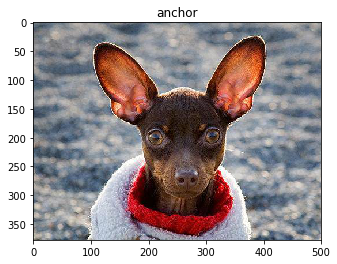

./input/train-2/cf8646d1cee707152f2590d8a7c2c82f.jpg
miniature_pinscher


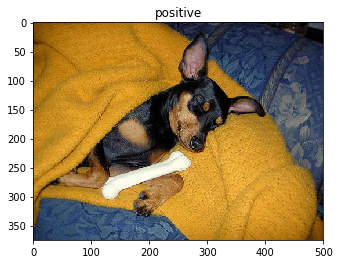

./input/train-2/890727594626c0fa7092624bb9261387.jpg
miniature_pinscher


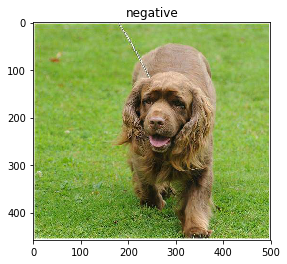

./input/train-2/2154516e54dc02add050a8a885207d29.jpg
sussex_spaniel


In [7]:
def show_triplets(df_triplets):
    row = df_triplets.iloc[random.randint(0, df_triplets.shape[0]-1)]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['anchor_id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(row['anchor_type'])
    positive_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['positive_id'])
    img = Image.open(positive_path)
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    print(positive_path)
    print(row['positive_type'])
    negative_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['negative_id'])
    img = Image.open(negative_path)
    plt.imshow(img)
    plt.title('negative')
    plt.show()
    print(negative_path)
    print(row['negative_type'])

show_triplets(df_triplets)
show_triplets(df_triplets)
show_triplets(df_triplets)


In [20]:
encoding_model = input_encoding_model((1, ENCODING_SIZE))
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001

def load_triplets(df_triplets):
    n_triplets = df_triplets.shape[0]
    anchors = np.zeros((n_triplets, 1, ENCODING_SIZE))
    pos = np.zeros((n_triplets, 1, ENCODING_SIZE))
    negs = np.zeros((n_triplets, 1, ENCODING_SIZE))

    i = 0
    max_ri = 0
    for ri, triplet in df_triplets.iterrows():
        anchors[i] = np.loadtxt(triplet['anchor_encoding'])
        pos[i] = np.loadtxt(triplet['positive_encoding'])
        negs[i] = np.loadtxt(triplet['negative_encoding'])
        i = i + 1
        if (i % 1000 == 0):
            display('Loaded ' + str(i) + ' triplets')
        max_ri = ri
    return anchors, pos, negs



### Load the encoding for the given triplets into memory
### Train the model with the whole training set

because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies


In [22]:
# anchors, pos, negs = load_triplets(df_triplets)
# n_triplets = df_triplets.shape[0]
# y_dummies = np.zeros((n_triplets, 1, n_triplets))


def generator(df_labels, batch_size):
    n_triplets = batch_size
    s = 0
    while True:
        e = s+n_triplets
        print(str(s) + ' ' + str(e))
        df_triplets = df_labels.iloc[s:e]
        y_dummies = np.zeros((n_triplets, 1, n_triplets))
        anchors, pos, negs = load_triplets(df_triplets)
        s = s + n_triplets
        yield [anchors, pos, negs], [y_dummies, y_dummies, y_dummies]

batch_size = 1024
steps_per_epoch = int(df_triplets.shape[0]/batch_size)
display('steps per epoch ' + str(steps_per_epoch))

training_model.fit_generator(generator=generator(df_triplets, batch_size=batch_size), epochs=1, steps_per_epoch=steps_per_epoch, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))


df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
df_train_results_mismatch.head()

'steps per epoch 11333'

Epoch 1/10 1024



'Loaded 1000 triplets'

Loaded 1024
Row index 1023
1024 2048
    1/11333 [..............................] - ETA: 42:20:13 - loss: 0.1384 - inputEncodingModel_loss_1: 0.0711 - inputEncodingModel_loss_2: 0.0259 - inputEncodingModel_loss_3: 0.0414 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

'Loaded 1000 triplets'

Loaded 1024
Row index 2047
2048 3072
    2/11333 [..............................] - ETA: 41:21:25 - loss: 0.5024 - inputEncodingModel_loss_1: 0.0371 - inputEncodingModel_loss_2: 0.3933 - inputEncodingModel_loss_3: 0.0720 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

'Loaded 1000 triplets'

Loaded 1024
Row index 3071
3072 4096
    3/11333 [..............................] - ETA: 41:25:10 - loss: 0.4692 - inputEncodingModel_loss_1: 0.1009 - inputEncodingModel_loss_2: 0.2755 - inputEncodingModel_loss_3: 0.0928 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

'Loaded 1000 triplets'

Loaded 1024
Row index 4095
4096 5120
    4/11333 [..............................] - ETA: 43:08:09 - loss: 0.4114 - inputEncodingModel_loss_1: 0.0935 - inputEncodingModel_loss_2: 0.2244 - inputEncodingModel_loss_3: 0.0934 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

'Loaded 1000 triplets'

Loaded 1024
Row index 5119
5120 6144
    5/11333 [..............................] - ETA: 43:00:19 - loss: 0.4886 - inputEncodingModel_loss_1: 0.1530 - inputEncodingModel_loss_2: 0.2577 - inputEncodingModel_loss_3: 0.0780 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

'Loaded 1000 triplets'

Loaded 1024
Row index 6143
6144 7168
    6/11333 [..............................] - ETA: 43:15:19 - loss: 0.6023 - inputEncodingModel_loss_1: 0.2701 - inputEncodingModel_loss_2: 0.2406 - inputEncodingModel_loss_3: 0.0915 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
def triplet_tuple(id_value, breed_value, encoding_value):
    return [id_value, breed_value, encoding_value]

def create_triplet(anchor_tuple, positive_tuple, negative_tuple):
    result = []
    for value in anchor_tuple:
        result.append(value)
    for value in positive_tuple:
        result.append(value)
    for value in negative_tuple:
        result.append(value)
    return result

def extract_triplets(df_mismatch, df_train):
    new_triplets_list = []

    for i, bad_pred in df_mismatch.iterrows():
        pred_anchors = df_train.loc[(df_train.breed == bad_pred.breed)]
        for i, pred_anchor in pred_anchors.iterrows():
            anchor = triplet_tuple(pred_anchor['id'], pred_anchor['breed'], pred_anchor['encoding'])
            positive = triplet_tuple(bad_pred['id'], bad_pred['breed'], bad_pred['encoding'])
            negative = triplet_tuple(bad_pred['prediction_id'], bad_pred['prediction_breed'], bad_pred['prediction_encoding'])
            new_triplets_list.append(create_triplet(anchor, positive, negative))
#             new_triplets_list.append(create_triplet(positive, anchor, negative))

    df_new_triplets = pd.DataFrame(new_triplets_list, columns=['anchor_id', 'anchor_type', 'anchor_encoding', 'positive_id', 'positive_type', 'positive_encoding', 'negative_id', 'negative_type', 'negative_encoding'])
    return df_new_triplets

### Load the bad prediction and train the model to recognize these against the corresponding anchors

In [ ]:
df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
print(df_new_triplets.shape)
df_new_triplets.head()

anchors, pos, negs = load_triplets(df_new_triplets)
n_triplets = df_new_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=50, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))

df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
